In [1]:
from mancha_de_inundacao import *
import rasterio
import rasterio.mask
from rasterio.plot import show
import geopandas
import fiona
import matplotlib.pyplot as plt

In [2]:
fiona.supported_drivers['KML'] = 'rw'

In [3]:
lat=-30.8767 
long=-54.1869
v=2100000
h=9

In [4]:
ponto_informado = Point((long, lat))

In [5]:
crio(v)

12.191161450700001

In [6]:
qmax_barr = qmax_barragem(h, v)

In [7]:
qmax_barr

678.4285170017035

In [8]:
srtm = rasterio.open('arquivos_para_testes/s31_w055_3arc_v2.tif')

In [9]:
cotas(ponto_informado, srtm, h)

(235, 244)

In [10]:
tracado = geopandas.read_file('arquivos_para_testes/tracado_do_rio.kml', driver='KML')

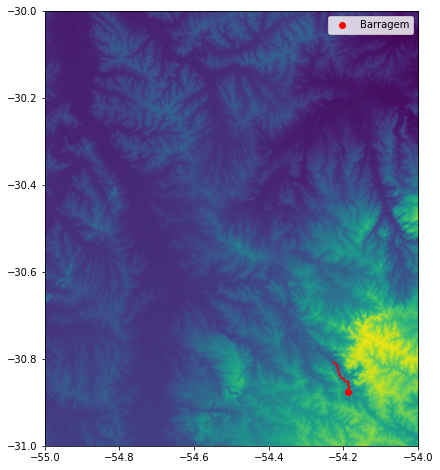

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
show(srtm, ax=ax)

ax.scatter(ponto_informado.x, ponto_informado.y, color='red', label='Barragem')

tracado.plot(ax=ax, color='red')

plt.legend()
plt.show()

In [12]:
srtm.crs

CRS.from_epsg(4326)

In [13]:
tracado_simplificado = simplificar_tracado(tracado, 8)

<AxesSubplot:>

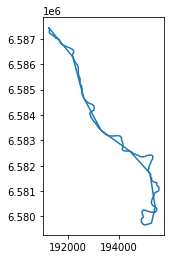

In [14]:
tracado_simplificado.plot()

In [15]:
s, ds = secoes_perpendiculares(tracado_simplificado)

<AxesSubplot:>

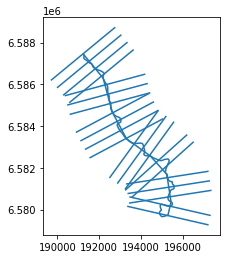

In [16]:
s.plot()

In [17]:
s.to_file('C:/Users/Roberto Rolo/Documents/GitHub/mancha_de_inundacao/test.shp')

<ipython-input-17-dea821c8fe6e>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  s.to_file('C:/Users/Roberto Rolo/Documents/GitHub/mancha_de_inundacao/test.shp')


In [18]:
minx, miny, maxx, maxy = min(s.bounds['minx']), min(s.bounds['miny']), max(s.bounds['maxx']), max(s.bounds['maxy'])

In [19]:
c, dp, xs, ys = cotas_secoes(s, srtm)

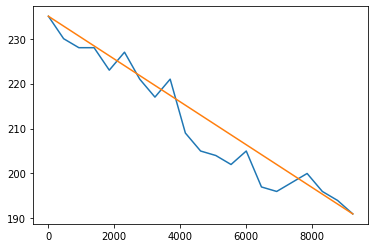

In [20]:
ct = [i[40] for i in c]
plt.plot(ds, ct)
plt.plot([ds[0], ds[-1]], [ct[0], ct[-1]])
j = (ct[0] - ct[-1])/ds[-1]

In [21]:
j

0.004762073746223796

In [22]:
qs = []
for i in ds:
    qs.append(qmax_secao(i, qmax_barr, v))

In [23]:
qs

[678.4285170017035,
 594.401001559942,
 520.7808071171851,
 456.27892340332215,
 399.7659919430329,
 350.2525322059033,
 306.8716168686228,
 268.86369285177057,
 235.56328236390408,
 206.38733110256388,
 180.8249996017477,
 158.42871898335173,
 138.80635450842402,
 121.61433972045789,
 106.55166096697216,
 93.35458697483459,
 81.79205119987176,
 71.66160610068188,
 62.78587850034666,
 55.009463973244486,
 48.196205881024234]

In [24]:
areas = []
raios = []
for cotas in c: 
    a, r, h = raio_hidraulico(cotas, dp)
    areas.append(a)
    raios.append(r)
alturas = h

In [25]:
qs = []
for idx in range(len(areas[0])):
    q = manning(areas[0][idx], raios[0][idx], j)
    qs.append(q)

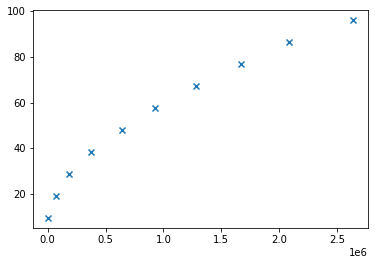

In [26]:
plt.scatter(qs, alturas[1:], marker='x')

In [27]:
a = polyfit(qs, alturas[1:], np.linspace(min(qs),max(qs), 100))

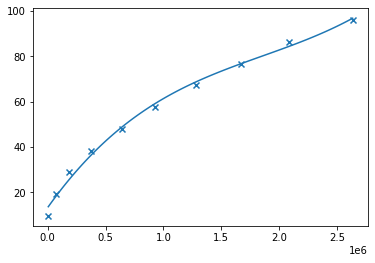

In [28]:
plt.plot(np.linspace(min(qs),max(qs), 100), a)
plt.scatter(qs, alturas[1:], marker='x')

In [29]:
clip_raster(s, srtm, 'teste')

In [30]:
clipado = rasterio.open('teste')

In [41]:
coords, z, w, h = get_coordinates(clipado)

In [42]:
from pyevtk.hl import pointsToVTK, gridToVTK

In [43]:
pointsToVTK('terreno', np.array(coords[0]), np.array(coords[1]), np.array(z).astype(float), data={'h':np.array(z)})

'c:\\Users\\Roberto Rolo\\Documents\\GitHub\\mancha_de_inundacao\\terreno.vtu'

No handles with labels found to put in legend.


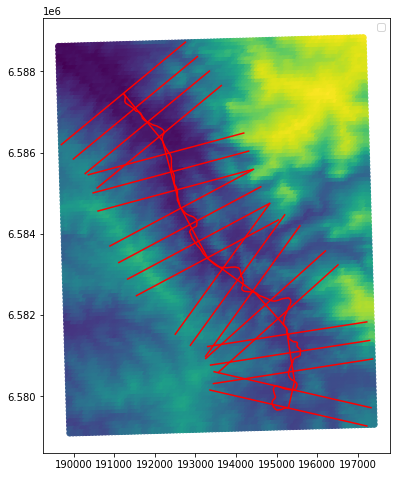

In [44]:
fig, ax = plt.subplots(figsize=(8,8))
#show(clipado, ax=ax)
ax.scatter(coords[0], coords[1], c=z)

#ax.scatter(ponto_informado.x, ponto_informado.y, color='red', label='Barragem')


#s.crs = 'EPSG:31982'
#s = s.to_crs(epsg=4326)


s.plot(ax=ax, color='red')

plt.legend()
plt.show()

In [45]:
alturas = altura_de_agua_secoes(ds, dp, c, qmax_barr, v)

In [46]:
x_all = []
y_all = []
h_all = []
for idx, v in enumerate(alturas):
    for idx1 in range(len(xs[idx])):
        h_all.append(v)
        x_all.append(xs[idx][idx1])
        y_all.append(ys[idx][idx1])

In [47]:
pointsToVTK('altura_secs', np.array(x_all), np.array(y_all), np.array(h_all), data={'h':np.array(h_all)})

'c:\\Users\\Roberto Rolo\\Documents\\GitHub\\mancha_de_inundacao\\altura_secs.vtu'

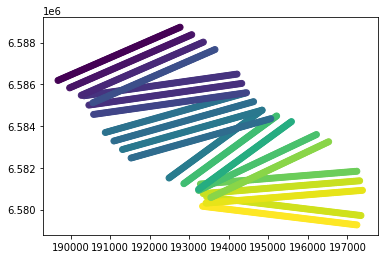

In [48]:
plt.scatter(x_all, y_all, c=h_all)

In [51]:
v_int = rbf_interpolation(x_all, y_all, h_all, coords[0], coords[1])

In [52]:
v_int

array([238.27049818, 236.82261613, 235.41005357, ..., 248.0262832 ,
       249.16482237, 250.65258635])

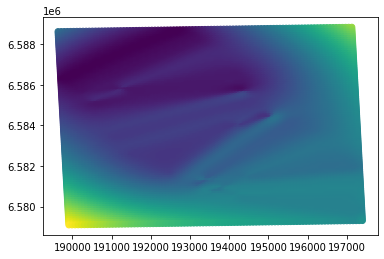

In [53]:
plt.scatter(coords[0], coords[1], c=v_int)

In [54]:
mancha = np.where(v_int > z, 1, 0)

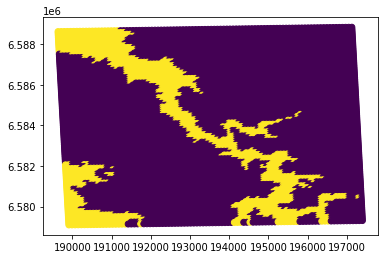

In [55]:
plt.scatter(coords[0], coords[1], c=mancha)
#plt.scatter(x_all, y_all, c=h_all)

In [151]:
mancha = np.where(v_int > z, 1., 0.)

In [163]:
import simplekml

def points_to_kml(x, y, mancha):
    x = np.array(x)
    y = np.array(y)
    f = mancha == 1
    x = x[f]
    y = y[f]
    xy = transformacao(x, y, d_to_m=False, new=True)

    kml = simplekml.Kml()
    for x, y in zip(xy[0], xy[1]):    
        pnt = kml.newpoint(description='ponto inundado', coords=[(y, x)])
        pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/water.png'
        pnt.style.iconstyle.scale = 0.5
    
    kml.save("pontos_inundados.kml")

In [164]:
points_to_kml(coords[0], coords[1], mancha)

<ipython-input-127-c5d9137df290>:1: UserWarning: No contour levels were found within the data range.
  cs = plt.contour(coords[0][:w],coords[1][::w],mancha.reshape(h, w), [0.])


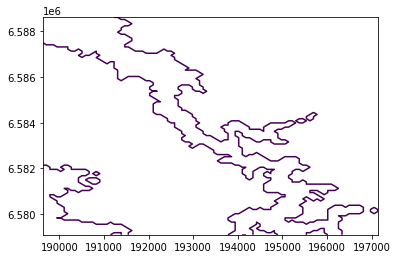

In [127]:
cs = plt.contour(coords[0][:w],coords[1][::w],mancha.reshape(h, w), [0.])

In [132]:
for i in range(len(cs.collections)):
    p = cs.collections[i].get_paths()[0]
    v = p.vertices
    x = v[:,0]
    y = v[:,1]
    poly = Polygon([(i[0], i[1]) for i in zip(x,y)])
    print(i, poly)

0 POLYGON ((191227.639273965 6588616.476932726, 191307.4245759203 6588616.476932726, 191387.2098466001 6588524.054682214, 191466.9950860126 6588524.054682214, 191546.7802941656 6588431.632423623, 191626.5654710665 6588339.210156948, 191546.7802941656 6588246.787882194, 191466.9950860126 6588246.787882194, 191387.2098466001 6588154.365599358, 191387.2098466001 6588061.943308439, 191307.4245759203 6587969.52100944, 191387.2098466001 6587877.098702358, 191466.9950860126 6587877.098702358, 191546.7802941656 6587784.676387194, 191626.5654710665 6587692.254063948, 191626.5654710665 6587599.83173262, 191546.7802941656 6587507.40939321, 191466.9950860126 6587414.987045718, 191466.9950860126 6587322.564690143, 191546.7802941656 6587322.564690143, 191626.5654710665 6587230.142326484, 191706.3506167238 6587137.719954742, 191786.1357311464 6587137.719954742, 191865.920814341 6587137.719954742, 191945.7058663165 6587045.29757492, 192025.4908870806 6587045.29757492, 192105.2758766423 6587045.2975749

AttributeError: 'Polygon' object has no attribute 'plot'

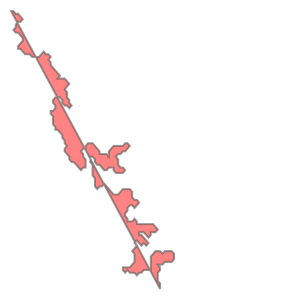

In [133]:
poly